In [134]:
%pip install chardet geopandas matplotlib numpy pandas scipy seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [135]:
import chardet
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.stats as stats

In [136]:
# Data files:
ROOT_DIR = pathlib.Path(os.getcwd())
DATA_DIR = ROOT_DIR / "data"

# Process PHS Seven Day Average Data

In [137]:
# Data files:
AVG_DATA_FILE = DATA_DIR / "PHS" / "Seven day average of wastewater sample (Retrieved 2024-09-05).csv"


In [138]:
# Determine the encoding of the input file:
with open(AVG_DATA_FILE, 'rb') as data:
    AVG_DATA_ENCODING = chardet.detect(data.read())['encoding']

In [139]:
# Read the data:
AVG_DATA = pd.read_csv(AVG_DATA_FILE, encoding=AVG_DATA_ENCODING, sep=',')

# Process SEPA RNA Monitoring Data

In [140]:
# Data files:
RNA_DATA_FILE = DATA_DIR / "SEPA" / "Wastewater" / "RNAMonitoring_Public - Result Description - N1 Gene, Reported Value - N1 Gene (gc-l), Days Since (Retrieved 2024-09-05).csv"

In [141]:
# Determine the encoding of the input file:
with open(RNA_DATA_FILE, 'rb') as data:
    RNA_DATA_ENCODING = chardet.detect(data.read())['encoding']

In [142]:
# Read the data:
rna_data = pd.read_csv(RNA_DATA_FILE, encoding=RNA_DATA_ENCODING, sep='\t')

In [143]:
# Column names:
HEALTH_AREA = 'Health Area'
SITE_NAME = 'Site Name'
POPULATION_SIZE = 'Population'
DATE = 'Date'
VALUE = 'Reported Value - N1 Gene (gc/l)'
VALUE_PER_1000 = 'Reported Value - N1 Gene per 1000 People (gc/l)'
VALUE_PER_PERSON = 'Reported Value - N1 Gene per person (gc/l)'

# Column values:
SITE_NAMES = rna_data[SITE_NAME].unique()
HEALTH_AREA_GGC = 'Greater Glasgow and Clyde'

# Outliers - number of standard deviations:
OUTLIER_STD_DEV = 3

In [144]:
# Check that each sample was taken on a different date:
for site_name in SITE_NAMES:
    assert rna_data[rna_data[SITE_NAME] == site_name][DATE].is_unique

In [145]:
# Remove outliers:
rna_data = rna_data[np.abs(stats.zscore(rna_data[VALUE])) < OUTLIER_STD_DEV]

In [146]:
# Remove samples without specified population:
rna_data = rna_data[rna_data[POPULATION_SIZE] != '(Empty)']

In [147]:
# Convert the date:
def parse_datetime(date):
    if not isinstance(date, datetime.datetime):
        month, day, year = map(int, date.split("/"))
        return datetime.datetime(year, month, day)
    else:
        return date

# Create a datetime index:
rna_data[DATE] = pd.DatetimeIndex(rna_data[DATE].map(parse_datetime))

In [148]:
# Convert the population size:
def parse_population_size(population_size):
    try:
        return int(population_size)
    except ValueError:
        return None

# Parse the population size:
rna_data[POPULATION_SIZE] = rna_data[POPULATION_SIZE].map(parse_population_size)

# Add value per person:
rna_data[VALUE_PER_PERSON] = rna_data[VALUE] / rna_data[POPULATION_SIZE]

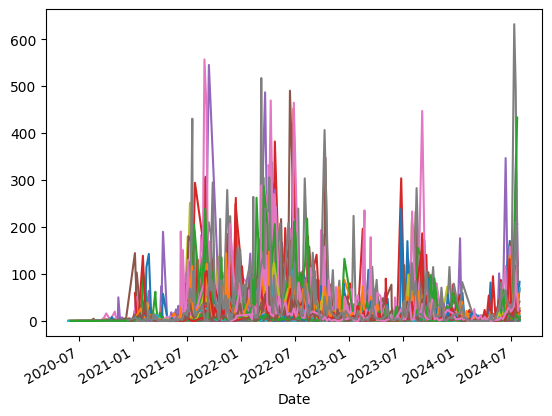

In [149]:
# Plot the value per person for each monitorint site:
# NOTE: The y-axis plots Gene copies per liter per person per day.
_ = rna_data.groupby(SITE_NAME).apply(lambda df_sn: df_sn.set_index(DATE)[VALUE_PER_PERSON].plot(), include_groups=False)

# Visualise SEPA RNA Monitoring Data As Choropleth

In [150]:
# Data files:
HEALTH_BOARD_MAP_SHAPE_FILE = DATA_DIR / "SG_NHS_HealthBoards_2019" / "SG_NHS_HealthBoards_2019.shp"

In [151]:
# Read the data:
health_board_map = gpd.read_file(HEALTH_BOARD_MAP_SHAPE_FILE)

In [152]:
# Summarise population data per NHS health board:
population_data = (
    rna_data[[HEALTH_AREA, SITE_NAME, POPULATION_SIZE]]
        .set_index(HEALTH_AREA)
        .drop_duplicates()
        .groupby(HEALTH_AREA)
        .sum(POPULATION_SIZE)
)

In [153]:
# Merge the NHS health board map data with the population data:
health_board_population_map_data = health_board_map.set_index('HBName').join(population_data)

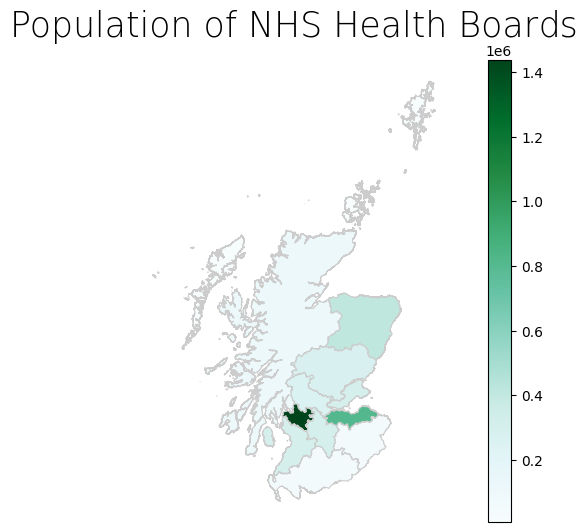

In [154]:
# Plot the population of each NHS health board as a choropleth:
POPULATION_SIZE_MIN = population_data[POPULATION_SIZE].min()
POPULATION_SIZE_MAX = population_data[POPULATION_SIZE].max()

fig, ax = plt.subplots(1, figsize=(10, 6))

# Plot figure:
health_board_population_map_data.plot(
    column=POPULATION_SIZE,
    cmap='BuGn',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
)

# Remove the axis:
ax.axis('off')

# Add a title:
ax.set_title(
    "Population of NHS Health Boards",
    fontdict={
        'fontsize': '25',
        'fontweight': '3'
    }
)

# Create colorbar as legend:
sm = plt.cm.ScalarMappable(
    cmap='BuGn',
    norm=plt.Normalize(vmin=POPULATION_SIZE_MIN, vmax=POPULATION_SIZE_MAX)
)

# Add empty array as data range
sm._A = []

# Add colorbar to figure
cbar = fig.colorbar(sm, ax=ax)